# 🔍 Self-Supervised Learning vs Transfer Learning vs Training from Scratch on CIFAR-10 (10% Labeled)

This notebook compares three different training strategies for image classification using the CIFAR-10 dataset, especially in a low-label regime (only 1,000 labeled examples):

---

### 🧪 Goal:
To evaluate how well different approaches perform when trained on limited labeled data (10% or 1,000 images), using the full test set for evaluation.

---

### 🧱 Dataset Overview:
- **CIFAR-10**: 50,000 training images, 10,000 test images, 10 classes.
- **Labeled Subset**: Stratified 1,000 images (100 per class) used for fine-tuning and from-scratch training.
- **Unlabeled Subset**: Remaining 90% (49,000 images) used for SSL pretext task.

---

### 📊 Compared Strategies:

| Strategy               | Description                                                                 |
|------------------------|-----------------------------------------------------------------------------|
| ❌ **From Scratch**     | Train a CNN using only 1,000 labeled images.                               |
| 🌍 **Transfer Learning**| Fine-tune a ResNet18 pretrained on ImageNet using the same 1,000 images.   |
| 🧠 **SSL + Fine-Tune**  | Pretrain a CNN using a self-supervised rotation prediction task, then fine-tune on 1,000 labeled images. |

---

### 🧠 Pretext Task (SSL):
We train a CNN to predict the rotation angle (0°, 90°, 180°, 270°) of images from the 90% unlabeled training set. The learned features are then used for downstream classification with minimal labels.

---

### 🧾 Evaluation:
All models are evaluated on the **full 10,000-image test set**, and results are compared using accuracy.



### 🔧 Step 1: Import Libraries and Setup Device
This cell imports all necessary packages and checks for GPU availability.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.models as models
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from collections import defaultdict
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seed for reproducibility
random.seed(42)

### 🔁 Step 2: Create Rotation Dataset for SSL
- Rotates each image randomly by 0, 90, 180, or 270 degrees.
- The model must predict the rotation angle (pretext task).


In [2]:
class RotationDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.angles = [0, 90, 180, 270]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        angle = random.choice(self.angles)
        rotated = transforms.functional.rotate(img, angle)
        label = self.angles.index(angle)
        return rotated, label


### 📂 Step 3: Load CIFAR-10 & Split
- 1000 image of CIFAR-10 is used for training.
- The remaining is used for the SSL pretext task.


In [3]:
# Load full CIFAR-10 training dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])
train_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Step 1: Access labels
labels = train_full.targets

# Step 2: Group indices by class
class_indices = defaultdict(list)
for idx, label in enumerate(labels):
    class_indices[label].append(idx)

# Step 3: Stratified sample (100 per class => 1000 total)
subset_indices = []
for class_id in range(10):
    sampled = random.sample(class_indices[class_id], 50)
    subset_indices.extend(sampled)

# Fine-tuning / Supervised Subset (1000 images)
train_subset = Subset(train_full, subset_indices)
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)

# SSL uses the remaining data (full set minus the 1000 labeled)
ssl_indices = list(set(range(len(train_full))) - set(subset_indices))
ssl_dataset_for_rotation = Subset(train_full, ssl_indices)
rotation_loader = DataLoader(RotationDataset(ssl_dataset_for_rotation), batch_size=128, shuffle=True)

# Test Set
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)


100%|██████████| 170M/170M [00:05<00:00, 31.5MB/s] 


### 🧱 Step 4: Small CNN Model
A simple 2-layer CNN to be used for:
- SSL pretraining
- Scratch training

In [5]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


### ⚙️ Step 5: Train & Evaluate Functions
Modular training and evaluation


In [6]:
def train(model, loader, optimizer, criterion=None, epochs=10, desc="Training"):
    model.train()
    if criterion is None:
        criterion = nn.CrossEntropyLoss()

    print(f"\n🔧 {desc} started...\n")
    for epoch in range(epochs):
        correct, total = 0, 0
        epoch_loss = 0
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}")
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            epoch_loss += loss.item()

            pbar.set_postfix(loss=loss.item(), acc=correct / total)

        print(f"✅ Epoch {epoch+1}: Accuracy = {correct/total:.2%}, Avg Loss = {epoch_loss/len(loader):.4f}")

    print(f"✅ {desc} completed.\n")

def evaluate(model, loader, desc="Evaluation"):
    model.eval()
    correct, total = 0, 0
    print(f"🔎 {desc} running...")
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc=desc):
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    print(f"✅ {desc} Accuracy: {acc:.2%}\n")
    return acc


### 🧠 Step 6: SSL Pretext Training (Rotation)
Train the model to predict rotation angle using the 90% unlabeled data.


In [7]:
class RotationHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = SmallCNN(num_classes=4)

    def forward(self, x):
        return self.backbone(x)

print("🧠 Training SSL Pretext (Rotation on 90%)...")
rotation_model = RotationHead().to(device)
optimizer_ssl_pretext = torch.optim.Adam(rotation_model.parameters(), lr=1e-3)
train(rotation_model, rotation_loader, optimizer_ssl_pretext, epochs=50, desc="SSL Pretext Task")

ssl_backbone = rotation_model.backbone.features  # Extract backbone


🧠 Training SSL Pretext (Rotation on 90%)...

🔧 SSL Pretext Task started...



Epoch 1/50: 100%|██████████| 387/387 [00:22<00:00, 17.17it/s, acc=0.541, loss=0.911]


✅ Epoch 1: Accuracy = 54.06%, Avg Loss = 1.0764


Epoch 2/50: 100%|██████████| 387/387 [00:21<00:00, 18.12it/s, acc=0.625, loss=0.847]


✅ Epoch 2: Accuracy = 62.52%, Avg Loss = 0.9202


Epoch 3/50: 100%|██████████| 387/387 [00:21<00:00, 17.81it/s, acc=0.655, loss=0.737]


✅ Epoch 3: Accuracy = 65.49%, Avg Loss = 0.8512


Epoch 4/50: 100%|██████████| 387/387 [00:21<00:00, 17.72it/s, acc=0.677, loss=0.823]


✅ Epoch 4: Accuracy = 67.74%, Avg Loss = 0.8077


Epoch 5/50: 100%|██████████| 387/387 [00:22<00:00, 17.53it/s, acc=0.69, loss=0.71]  


✅ Epoch 5: Accuracy = 68.96%, Avg Loss = 0.7754


Epoch 6/50: 100%|██████████| 387/387 [00:21<00:00, 17.86it/s, acc=0.701, loss=0.664]


✅ Epoch 6: Accuracy = 70.09%, Avg Loss = 0.7472


Epoch 7/50: 100%|██████████| 387/387 [00:21<00:00, 18.14it/s, acc=0.713, loss=0.721]


✅ Epoch 7: Accuracy = 71.25%, Avg Loss = 0.7239


Epoch 8/50: 100%|██████████| 387/387 [00:21<00:00, 17.83it/s, acc=0.72, loss=0.551] 


✅ Epoch 8: Accuracy = 71.97%, Avg Loss = 0.7028


Epoch 9/50: 100%|██████████| 387/387 [00:21<00:00, 18.18it/s, acc=0.731, loss=0.884]


✅ Epoch 9: Accuracy = 73.08%, Avg Loss = 0.6783


Epoch 10/50: 100%|██████████| 387/387 [00:21<00:00, 18.37it/s, acc=0.74, loss=0.708] 


✅ Epoch 10: Accuracy = 74.04%, Avg Loss = 0.6642


Epoch 11/50: 100%|██████████| 387/387 [00:21<00:00, 17.82it/s, acc=0.746, loss=0.505]


✅ Epoch 11: Accuracy = 74.60%, Avg Loss = 0.6447


Epoch 12/50: 100%|██████████| 387/387 [00:20<00:00, 18.48it/s, acc=0.751, loss=0.625]


✅ Epoch 12: Accuracy = 75.12%, Avg Loss = 0.6351


Epoch 13/50: 100%|██████████| 387/387 [00:21<00:00, 18.20it/s, acc=0.758, loss=0.485]


✅ Epoch 13: Accuracy = 75.80%, Avg Loss = 0.6175


Epoch 14/50: 100%|██████████| 387/387 [00:21<00:00, 18.23it/s, acc=0.763, loss=0.704]


✅ Epoch 14: Accuracy = 76.29%, Avg Loss = 0.6049


Epoch 15/50: 100%|██████████| 387/387 [00:21<00:00, 18.39it/s, acc=0.769, loss=0.638]


✅ Epoch 15: Accuracy = 76.92%, Avg Loss = 0.5902


Epoch 16/50: 100%|██████████| 387/387 [00:21<00:00, 18.29it/s, acc=0.772, loss=0.645]


✅ Epoch 16: Accuracy = 77.24%, Avg Loss = 0.5811


Epoch 17/50: 100%|██████████| 387/387 [00:21<00:00, 18.23it/s, acc=0.779, loss=0.388]


✅ Epoch 17: Accuracy = 77.94%, Avg Loss = 0.5663


Epoch 18/50: 100%|██████████| 387/387 [00:21<00:00, 18.16it/s, acc=0.787, loss=0.527]


✅ Epoch 18: Accuracy = 78.74%, Avg Loss = 0.5548


Epoch 19/50: 100%|██████████| 387/387 [00:21<00:00, 18.36it/s, acc=0.788, loss=0.44] 


✅ Epoch 19: Accuracy = 78.84%, Avg Loss = 0.5467


Epoch 20/50: 100%|██████████| 387/387 [00:21<00:00, 18.23it/s, acc=0.793, loss=0.703]


✅ Epoch 20: Accuracy = 79.30%, Avg Loss = 0.5386


Epoch 21/50: 100%|██████████| 387/387 [00:21<00:00, 18.30it/s, acc=0.796, loss=0.551]


✅ Epoch 21: Accuracy = 79.62%, Avg Loss = 0.5277


Epoch 22/50: 100%|██████████| 387/387 [00:20<00:00, 18.50it/s, acc=0.803, loss=0.494]


✅ Epoch 22: Accuracy = 80.27%, Avg Loss = 0.5121


Epoch 23/50: 100%|██████████| 387/387 [00:21<00:00, 18.25it/s, acc=0.807, loss=0.514]


✅ Epoch 23: Accuracy = 80.65%, Avg Loss = 0.5042


Epoch 24/50: 100%|██████████| 387/387 [00:21<00:00, 18.24it/s, acc=0.808, loss=0.425]


✅ Epoch 24: Accuracy = 80.77%, Avg Loss = 0.5036


Epoch 25/50: 100%|██████████| 387/387 [00:21<00:00, 18.23it/s, acc=0.816, loss=0.562]


✅ Epoch 25: Accuracy = 81.64%, Avg Loss = 0.4850


Epoch 26/50: 100%|██████████| 387/387 [00:21<00:00, 17.78it/s, acc=0.816, loss=0.534]


✅ Epoch 26: Accuracy = 81.64%, Avg Loss = 0.4796


Epoch 27/50: 100%|██████████| 387/387 [00:21<00:00, 17.83it/s, acc=0.82, loss=0.526] 


✅ Epoch 27: Accuracy = 82.04%, Avg Loss = 0.4721


Epoch 28/50: 100%|██████████| 387/387 [00:21<00:00, 17.86it/s, acc=0.825, loss=0.54] 


✅ Epoch 28: Accuracy = 82.51%, Avg Loss = 0.4608


Epoch 29/50: 100%|██████████| 387/387 [00:21<00:00, 17.81it/s, acc=0.828, loss=0.38] 


✅ Epoch 29: Accuracy = 82.81%, Avg Loss = 0.4544


Epoch 30/50: 100%|██████████| 387/387 [00:21<00:00, 17.66it/s, acc=0.828, loss=0.477]


✅ Epoch 30: Accuracy = 82.81%, Avg Loss = 0.4486


Epoch 31/50: 100%|██████████| 387/387 [00:21<00:00, 17.80it/s, acc=0.832, loss=0.551]


✅ Epoch 31: Accuracy = 83.17%, Avg Loss = 0.4441


Epoch 32/50: 100%|██████████| 387/387 [00:21<00:00, 18.09it/s, acc=0.837, loss=0.482]


✅ Epoch 32: Accuracy = 83.65%, Avg Loss = 0.4313


Epoch 33/50: 100%|██████████| 387/387 [00:21<00:00, 18.00it/s, acc=0.843, loss=0.399]


✅ Epoch 33: Accuracy = 84.32%, Avg Loss = 0.4208


Epoch 34/50: 100%|██████████| 387/387 [00:21<00:00, 18.21it/s, acc=0.841, loss=0.267]


✅ Epoch 34: Accuracy = 84.09%, Avg Loss = 0.4217


Epoch 35/50: 100%|██████████| 387/387 [00:21<00:00, 17.94it/s, acc=0.845, loss=0.333]


✅ Epoch 35: Accuracy = 84.45%, Avg Loss = 0.4129


Epoch 36/50: 100%|██████████| 387/387 [00:21<00:00, 17.99it/s, acc=0.848, loss=0.559]


✅ Epoch 36: Accuracy = 84.76%, Avg Loss = 0.4027


Epoch 37/50: 100%|██████████| 387/387 [00:21<00:00, 17.99it/s, acc=0.851, loss=0.514]


✅ Epoch 37: Accuracy = 85.13%, Avg Loss = 0.3960


Epoch 38/50: 100%|██████████| 387/387 [00:21<00:00, 17.76it/s, acc=0.854, loss=0.526]


✅ Epoch 38: Accuracy = 85.36%, Avg Loss = 0.3935


Epoch 39/50: 100%|██████████| 387/387 [00:21<00:00, 17.80it/s, acc=0.857, loss=0.462]


✅ Epoch 39: Accuracy = 85.75%, Avg Loss = 0.3829


Epoch 40/50: 100%|██████████| 387/387 [00:21<00:00, 18.23it/s, acc=0.858, loss=0.325]


✅ Epoch 40: Accuracy = 85.80%, Avg Loss = 0.3764


Epoch 41/50: 100%|██████████| 387/387 [00:21<00:00, 18.19it/s, acc=0.862, loss=0.395]


✅ Epoch 41: Accuracy = 86.18%, Avg Loss = 0.3714


Epoch 42/50: 100%|██████████| 387/387 [00:21<00:00, 17.79it/s, acc=0.863, loss=0.287]


✅ Epoch 42: Accuracy = 86.31%, Avg Loss = 0.3632


Epoch 43/50: 100%|██████████| 387/387 [00:21<00:00, 18.40it/s, acc=0.865, loss=0.329]


✅ Epoch 43: Accuracy = 86.53%, Avg Loss = 0.3556


Epoch 44/50: 100%|██████████| 387/387 [00:20<00:00, 19.22it/s, acc=0.868, loss=0.416]


✅ Epoch 44: Accuracy = 86.83%, Avg Loss = 0.3582


Epoch 45/50: 100%|██████████| 387/387 [00:20<00:00, 18.85it/s, acc=0.87, loss=0.306] 


✅ Epoch 45: Accuracy = 87.04%, Avg Loss = 0.3470


Epoch 46/50: 100%|██████████| 387/387 [00:20<00:00, 19.19it/s, acc=0.872, loss=0.256]


✅ Epoch 46: Accuracy = 87.22%, Avg Loss = 0.3426


Epoch 47/50: 100%|██████████| 387/387 [00:20<00:00, 19.11it/s, acc=0.874, loss=0.386]


✅ Epoch 47: Accuracy = 87.45%, Avg Loss = 0.3354


Epoch 48/50: 100%|██████████| 387/387 [00:20<00:00, 19.20it/s, acc=0.875, loss=0.395]


✅ Epoch 48: Accuracy = 87.54%, Avg Loss = 0.3341


Epoch 49/50: 100%|██████████| 387/387 [00:19<00:00, 19.55it/s, acc=0.879, loss=0.377]


✅ Epoch 49: Accuracy = 87.86%, Avg Loss = 0.3263


Epoch 50/50: 100%|██████████| 387/387 [00:19<00:00, 19.50it/s, acc=0.881, loss=0.34] 

✅ Epoch 50: Accuracy = 88.11%, Avg Loss = 0.3190
✅ SSL Pretext Task completed.



### 🔁 Step 7: Fine-tune SSL Backbone
Freeze backbone learned from rotation task and train a small classifier.


In [8]:
class SSLClassifier(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        for p in self.backbone.parameters():
            p.requires_grad = False
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8, 128), nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.backbone(x)
        return self.classifier(x)

ssl_model = SSLClassifier(ssl_backbone).to(device)
optimizer_ssl_finetune = torch.optim.Adam(ssl_model.parameters(), lr=1e-3)
train(ssl_model, train_loader, optimizer_ssl_finetune, epochs=10, desc="SSL Fine-tune")
ssl_acc = evaluate(ssl_model, test_loader, desc="SSL Eval")



🔧 SSL Fine-tune started...



Epoch 1/10: 100%|██████████| 8/8 [00:00<00:00, 85.33it/s, acc=0.312, loss=1.91]


✅ Epoch 1: Accuracy = 31.20%, Avg Loss = 2.1513


Epoch 2/10: 100%|██████████| 8/8 [00:00<00:00, 89.89it/s, acc=0.616, loss=1.34]


✅ Epoch 2: Accuracy = 61.60%, Avg Loss = 1.5564


Epoch 3/10: 100%|██████████| 8/8 [00:00<00:00, 94.18it/s, acc=0.786, loss=1.05]


✅ Epoch 3: Accuracy = 78.60%, Avg Loss = 1.1413


Epoch 4/10: 100%|██████████| 8/8 [00:00<00:00, 92.01it/s, acc=0.866, loss=0.723]


✅ Epoch 4: Accuracy = 86.60%, Avg Loss = 0.8194


Epoch 5/10: 100%|██████████| 8/8 [00:00<00:00, 92.72it/s, acc=0.924, loss=0.553]


✅ Epoch 5: Accuracy = 92.40%, Avg Loss = 0.5860


Epoch 6/10: 100%|██████████| 8/8 [00:00<00:00, 93.71it/s, acc=0.968, loss=0.344]


✅ Epoch 6: Accuracy = 96.80%, Avg Loss = 0.4056


Epoch 7/10: 100%|██████████| 8/8 [00:00<00:00, 91.88it/s, acc=0.982, loss=0.281]


✅ Epoch 7: Accuracy = 98.20%, Avg Loss = 0.2875


Epoch 8/10: 100%|██████████| 8/8 [00:00<00:00, 92.34it/s, acc=1, loss=0.212]


✅ Epoch 8: Accuracy = 100.00%, Avg Loss = 0.2015


Epoch 9/10: 100%|██████████| 8/8 [00:00<00:00, 89.60it/s, acc=1, loss=0.13]


✅ Epoch 9: Accuracy = 100.00%, Avg Loss = 0.1429


Epoch 10/10: 100%|██████████| 8/8 [00:00<00:00, 93.98it/s, acc=1, loss=0.0684]


✅ Epoch 10: Accuracy = 100.00%, Avg Loss = 0.1034
✅ SSL Fine-tune completed.

🔎 SSL Eval running...


SSL Eval: 100%|██████████| 157/157 [00:01<00:00, 113.12it/s]

✅ SSL Eval Accuracy: 49.29%



### 🌍 Step 8: Transfer Learning with ResNet18
Fine-tune a model pretrained on ImageNet using 10% CIFAR-10.


In [9]:
print("📦 Transfer Learning with Pretrained ResNet18 (Frozen)...")

resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1, bias=False)
resnet.maxpool = nn.Identity()
resnet.fc = nn.Linear(resnet.fc.in_features, 10)

# Freeze feature extractor
for p in resnet.parameters(): p.requires_grad = False
for p in resnet.fc.parameters(): p.requires_grad = True

resnet = resnet.to(device)
optimizer_resnet = torch.optim.Adam(resnet.fc.parameters(), lr=1e-3)

train(resnet, train_loader, optimizer_resnet, epochs=25, desc="Transfer Learning (Frozen)")
resnet_acc = evaluate(resnet, test_loader, desc="Transfer Eval")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


📦 Transfer Learning with Pretrained ResNet18 (Frozen)...


100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]



🔧 Transfer Learning (Frozen) started...



Epoch 1/25: 100%|██████████| 8/8 [00:00<00:00, 29.48it/s, acc=0.108, loss=2.35] 


✅ Epoch 1: Accuracy = 10.80%, Avg Loss = 2.4369


Epoch 2/25: 100%|██████████| 8/8 [00:00<00:00, 47.55it/s, acc=0.21, loss=2.2]  


✅ Epoch 2: Accuracy = 21.00%, Avg Loss = 2.1978


Epoch 3/25: 100%|██████████| 8/8 [00:00<00:00, 48.75it/s, acc=0.312, loss=1.87]


✅ Epoch 3: Accuracy = 31.20%, Avg Loss = 1.9995


Epoch 4/25: 100%|██████████| 8/8 [00:00<00:00, 48.91it/s, acc=0.396, loss=1.99]


✅ Epoch 4: Accuracy = 39.60%, Avg Loss = 1.8287


Epoch 5/25: 100%|██████████| 8/8 [00:00<00:00, 48.42it/s, acc=0.478, loss=1.56]


✅ Epoch 5: Accuracy = 47.80%, Avg Loss = 1.6852


Epoch 6/25: 100%|██████████| 8/8 [00:00<00:00, 48.78it/s, acc=0.542, loss=1.41]


✅ Epoch 6: Accuracy = 54.20%, Avg Loss = 1.5657


Epoch 7/25: 100%|██████████| 8/8 [00:00<00:00, 49.55it/s, acc=0.624, loss=1.37]


✅ Epoch 7: Accuracy = 62.40%, Avg Loss = 1.4604


Epoch 8/25: 100%|██████████| 8/8 [00:00<00:00, 49.23it/s, acc=0.614, loss=1.54]


✅ Epoch 8: Accuracy = 61.40%, Avg Loss = 1.4079


Epoch 9/25: 100%|██████████| 8/8 [00:00<00:00, 49.26it/s, acc=0.638, loss=1.33]


✅ Epoch 9: Accuracy = 63.80%, Avg Loss = 1.3368


Epoch 10/25: 100%|██████████| 8/8 [00:00<00:00, 49.21it/s, acc=0.67, loss=1.44] 


✅ Epoch 10: Accuracy = 67.00%, Avg Loss = 1.2797


Epoch 11/25: 100%|██████████| 8/8 [00:00<00:00, 49.12it/s, acc=0.69, loss=1.18] 


✅ Epoch 11: Accuracy = 69.00%, Avg Loss = 1.2055


Epoch 12/25: 100%|██████████| 8/8 [00:00<00:00, 49.52it/s, acc=0.704, loss=1.14]


✅ Epoch 12: Accuracy = 70.40%, Avg Loss = 1.1615


Epoch 13/25: 100%|██████████| 8/8 [00:00<00:00, 48.99it/s, acc=0.708, loss=1.1] 


✅ Epoch 13: Accuracy = 70.80%, Avg Loss = 1.1080


Epoch 14/25: 100%|██████████| 8/8 [00:00<00:00, 49.13it/s, acc=0.742, loss=1.07] 


✅ Epoch 14: Accuracy = 74.20%, Avg Loss = 1.0680


Epoch 15/25: 100%|██████████| 8/8 [00:00<00:00, 49.33it/s, acc=0.75, loss=1.2]   


✅ Epoch 15: Accuracy = 75.00%, Avg Loss = 1.0295


Epoch 16/25: 100%|██████████| 8/8 [00:00<00:00, 49.38it/s, acc=0.772, loss=0.892]


✅ Epoch 16: Accuracy = 77.20%, Avg Loss = 0.9893


Epoch 17/25: 100%|██████████| 8/8 [00:00<00:00, 48.17it/s, acc=0.744, loss=0.873]


✅ Epoch 17: Accuracy = 74.40%, Avg Loss = 0.9770


Epoch 18/25: 100%|██████████| 8/8 [00:00<00:00, 49.15it/s, acc=0.764, loss=0.821]


✅ Epoch 18: Accuracy = 76.40%, Avg Loss = 0.9152


Epoch 19/25: 100%|██████████| 8/8 [00:00<00:00, 49.03it/s, acc=0.796, loss=0.884]


✅ Epoch 19: Accuracy = 79.60%, Avg Loss = 0.8990


Epoch 20/25: 100%|██████████| 8/8 [00:00<00:00, 49.29it/s, acc=0.794, loss=0.824]


✅ Epoch 20: Accuracy = 79.40%, Avg Loss = 0.8608


Epoch 21/25: 100%|██████████| 8/8 [00:00<00:00, 48.78it/s, acc=0.826, loss=0.828]


✅ Epoch 21: Accuracy = 82.60%, Avg Loss = 0.8423


Epoch 22/25: 100%|██████████| 8/8 [00:00<00:00, 48.89it/s, acc=0.808, loss=0.813]


✅ Epoch 22: Accuracy = 80.80%, Avg Loss = 0.8124


Epoch 23/25: 100%|██████████| 8/8 [00:00<00:00, 48.12it/s, acc=0.846, loss=0.924]


✅ Epoch 23: Accuracy = 84.60%, Avg Loss = 0.7848


Epoch 24/25: 100%|██████████| 8/8 [00:00<00:00, 48.83it/s, acc=0.83, loss=0.881] 


✅ Epoch 24: Accuracy = 83.00%, Avg Loss = 0.8040


Epoch 25/25: 100%|██████████| 8/8 [00:00<00:00, 49.00it/s, acc=0.842, loss=0.798]


✅ Epoch 25: Accuracy = 84.20%, Avg Loss = 0.7515
✅ Transfer Learning (Frozen) completed.

🔎 Transfer Eval running...


Transfer Eval: 100%|██████████| 157/157 [00:03<00:00, 51.05it/s]

✅ Transfer Eval Accuracy: 36.43%



### 🏗️ Step 9: Train From Scratch
Train the same small CNN from scratch using only 10% labeled data.


In [10]:
print("🧪 Training From Scratch...")

scratch_model = SmallCNN(num_classes=10).to(device)
optimizer_scratch = torch.optim.Adam(scratch_model.parameters(), lr=1e-3)
train(scratch_model, train_loader, optimizer_scratch, epochs=10, desc="From Scratch")
scratch_acc = evaluate(scratch_model, test_loader, desc="Scratch Eval")


🧪 Training From Scratch...

🔧 From Scratch started...



Epoch 1/10: 100%|██████████| 8/8 [00:00<00:00, 87.15it/s, acc=0.092, loss=2.3]


✅ Epoch 1: Accuracy = 9.20%, Avg Loss = 2.3183


Epoch 2/10: 100%|██████████| 8/8 [00:00<00:00, 89.35it/s, acc=0.12, loss=2.26]


✅ Epoch 2: Accuracy = 12.00%, Avg Loss = 2.2795


Epoch 3/10: 100%|██████████| 8/8 [00:00<00:00, 89.38it/s, acc=0.266, loss=2.17]


✅ Epoch 3: Accuracy = 26.60%, Avg Loss = 2.2038


Epoch 4/10: 100%|██████████| 8/8 [00:00<00:00, 86.57it/s, acc=0.288, loss=2.04]


✅ Epoch 4: Accuracy = 28.80%, Avg Loss = 2.0604


Epoch 5/10: 100%|██████████| 8/8 [00:00<00:00, 88.10it/s, acc=0.316, loss=1.8]


✅ Epoch 5: Accuracy = 31.60%, Avg Loss = 1.9352


Epoch 6/10: 100%|██████████| 8/8 [00:00<00:00, 88.28it/s, acc=0.338, loss=1.95]


✅ Epoch 6: Accuracy = 33.80%, Avg Loss = 1.8479


Epoch 7/10: 100%|██████████| 8/8 [00:00<00:00, 86.74it/s, acc=0.366, loss=1.72]


✅ Epoch 7: Accuracy = 36.60%, Avg Loss = 1.7467


Epoch 8/10: 100%|██████████| 8/8 [00:00<00:00, 88.14it/s, acc=0.432, loss=1.51]


✅ Epoch 8: Accuracy = 43.20%, Avg Loss = 1.6582


Epoch 9/10: 100%|██████████| 8/8 [00:00<00:00, 87.72it/s, acc=0.476, loss=1.56]


✅ Epoch 9: Accuracy = 47.60%, Avg Loss = 1.5697


Epoch 10/10: 100%|██████████| 8/8 [00:00<00:00, 88.14it/s, acc=0.492, loss=1.49]


✅ Epoch 10: Accuracy = 49.20%, Avg Loss = 1.4855
✅ From Scratch completed.

🔎 Scratch Eval running...


Scratch Eval: 100%|██████████| 157/157 [00:01<00:00, 116.77it/s]

✅ Scratch Eval Accuracy: 33.17%



### 📊 Step 10: Compare Accuracies
Show all three methods side-by-side in a bar plot.


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


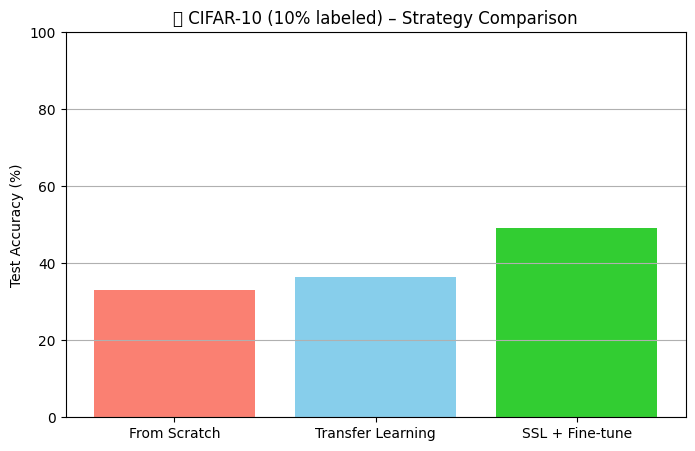

From Scratch: 33.17%
Transfer Learning: 36.43%
SSL + Fine-tune: 49.29%


In [11]:
labels = ["From Scratch", "Transfer Learning", "SSL + Fine-tune"]
scores = [scratch_acc * 100, resnet_acc * 100, ssl_acc * 100]

plt.figure(figsize=(8, 5))
plt.bar(labels, scores, color=["salmon", "skyblue", "limegreen"])
plt.ylabel("Test Accuracy (%)")
plt.title("📊 CIFAR-10 (10% labeled) – Strategy Comparison")
plt.ylim(0, 100)
plt.grid(axis="y")
plt.show()

for label, score in zip(labels, scores):
    print(f"{label}: {score:.2f}%")


## 📝 Try This: Boost Your SSL + Fine-tuning Results

Explore these experiments to improve your model's performance and deepen your understanding of self-supervised learning:

---

### 1️⃣ Use a More Complex CNN  
The current CNN used for SSL is intentionally simple.
🔧 Try replacing it with a more powerful architecture like:
- A deeper custom CNN
- ResNet18 or MobileNetV2

---

### 2️⃣ Use ResNet as the SSL Backbone  
Swap out the small CNN in the rotation pretext task with **ResNet18** (or another encoder).  
This allows you to learn much more expressive and transferable features.

> 🔁 Use the same idea: `RotationHead(backbone=ResNet18)`.

---

### 3️⃣ Tune Your Hyperparameters  
Try changing:
- Learning rate (`1e-2`, `1e-4`, etc.)
- Optimizer (`Adam`, `SGD`, `AdamW`)
- Batch size (32, 64, 128)
- Weight decay or momentum

---

### 4️⃣ ⏱️ Train SSL for Longer  
Self-supervised learning often requires **at least 100 epochs** to converge well.  
As you've seen, the rotation loss may still be decreasing at epoch 5.  
📈 Increase the number of SSL training epochs to improve the learned representation quality.




### contributed by: Yazan Alshoibi